In [ ]:
# Subscribe to both topics order buy and order sell
# Run the logic to create match and execute transactions

import random, pickle
from datetime import datetime, timedelta
from order_generation_utils import *
random.seed(42)
from collections import Counter
import pandas as pd
from tqdm import tqdm

ORDER_INFO = "order_info.pkl"

In [ ]:
order_data = pickle.load(open(ORDER_INFO, "rb"))

# Order Matching

In [ ]:
getattr(order_data[0], 'bid_time')

datetime.datetime(2023, 2, 28, 9, 30)

In [ ]:
print(order_data[0])

BIDDER: Vinayak | INSTRUMENT: Rakuten | BID TYPE: Buy | BID TIME: 09-30-00| BID PRICE:  398 INR| STATUS: ACTIVE   | TRANSACTION_TIME: None


In [ ]:
buy_orders = [x for x in order_data if x.bid_type == "Buy"]
sell_orders = [x for x in order_data if x.bid_type == "Sell"]

In [ ]:
instruments = set([x.bid_instrument for x in order_data])
entities = set([x.bidder for x in order_data])

In [ ]:
print(dir(order_data[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'bid_instrument', 'bid_price', 'bid_status', 'bid_time', 'bid_type', 'bidder', 'transaction_time']


In [ ]:
order_data = pickle.load(open(ORDER_INFO, "rb"))

In [ ]:
def resolve_instrument(orders, instrument):
    trades = []
    i_buy = [x for x in orders if ((x.bid_instrument == instrument) and (x.bid_type == "Buy"))]
    i_sell = [x for x in orders if ((x.bid_instrument == instrument) and (x.bid_type == "Sell"))]
    
    for sell_order in tqdm(i_sell, total = len(i_sell), desc = f"Matchmaking for {instrument}"):
        if sell_order.bid_status != "ACTIVE":
            continue
        older_buys = [x for x in i_buy if sell_order.bid_time >= x.bid_time]
        older_buys = sorted(older_buys, key = lambda x: x.bid_time)
        for buy_order in older_buys:
            
            if buy_order.bid_status != "ACTIVE":
                continue
            
            if buy_order.bid_price == sell_order.bid_price:
                transact_time = max(buy_order.bid_time, sell_order.bid_time)
                
                buy_order.bid_status = "BOUGHT"
                sell_order.bid_status = "SOLD"
                
                buy_order.transaction_time = transact_time
                sell_order.transaction_time = transact_time
                
                trades.append([buy_order, sell_order])
    return orders, trades

In [ ]:
trades = []
for instrument in instruments:
    order_data, instrument_trades = resolve_instrument(order_data, instrument)
    trades.extend(instrument_trades)

Matchmaking for Rakuten: 100%|████████████| 2177/2177 [00:00<00:00, 3120.00it/s]


In [ ]:
len(trades)

6171

# SMA Computation

In [ ]:
START_TIME = datetime(2023, 2, 28, 9, 30)
END_TIME = datetime(2023, 2, 28, 15, 30)

def sma_computation(instrument, trades, window_duration = 5 * 60, sma_duration = 10 * 60):
    
    # Start right from the beginning
    current_time = START_TIME
    
    # Store the values of the trades which are happening in a dictionary
    sma_map = {}
    
    # Loop over all the time tickers and check the trades for the instrument of choice
    # Compute the SMA in steps of window duration by considering a window of sma_duration
    while current_time < END_TIME:
        current_time = current_time + timedelta(0, window_duration)
        start = current_time - timedelta(0, sma_duration)

        window_start = max(START_TIME, start)
        window_end = min(END_TIME, current_time)

        bid_sum = 0; bid_count = 0;
        for trade in trades:
            if ((trade[0].transaction_time >= window_start) and (trade[0].transaction_time < window_end)):
                if trade[0].bid_instrument == instrument:
                    bid_sum += trade[0].bid_price
                    bid_count += 1

        sma_map[window_end] = [bid_sum, bid_count, round(bid_sum / bid_count, 3)]        
    return sma_map

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

In [ ]:
timestamps = list(sma_map.keys())
moving_averages = [x[-1] for x in sma_map.values()]

In [ ]:
sub_moving_averages[:10]

[406.556,
 403.781,
 405.03,
 403.128,
 404.521,
 407.016,
 408.0,
 409.024,
 407.125,
 404.636]

In [ ]:
len(sub_moving_averages[:10])

10

Plotting SMA chronologically: 100%|█████████████| 72/72 [00:18<00:00,  3.97it/s]


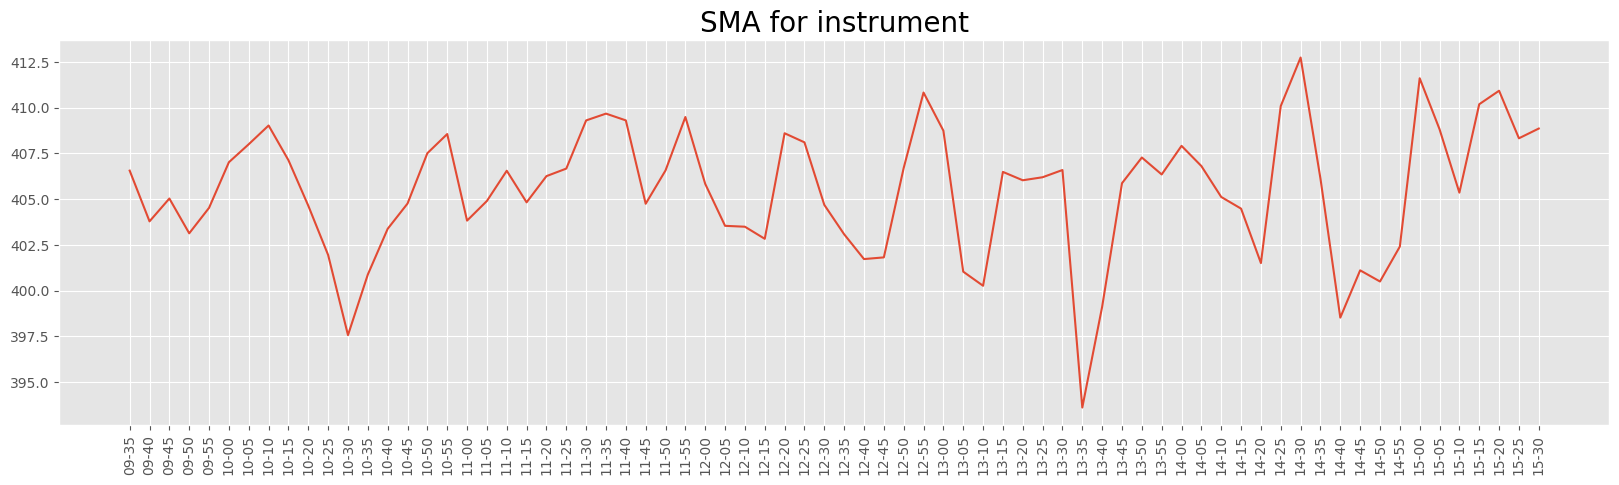

In [ ]:
plt.figure(figsize = (20,5))
plt.plot([x.strftime("%H-%M") for x in sma_map.keys()], [x[2] for x in sma_map.values()])
plt.xticks(rotation = 90);
plt.title(f"SMA for instrument", fontsize = 20);

# Closing/Opening Price Computation

In [ ]:
CLOSE_START_TIME = datetime(2023, 2, 28, 15, 0)
CLOSE_END_TIME = datetime(2023, 2, 28, 15, 30)

def close_price_computation(instrument, trades, close_start_time = CLOSE_START_TIME, close_end_time = CLOSE_END_TIME):
    
    traded_price = 0; traded_volume = 0
    
    for trade in trades:
        buy_order, sell_order = trade
        transact_time = buy_order.transaction_time
        if (transact_time >= CLOSE_START_TIME) and (transact_time <= CLOSE_END_TIME):
            if buy_order.bid_instrument == instrument:
                traded_price += buy_order.bid_price
                traded_volume += 1
    
    close_price = traded_price / traded_volume
    
    return close_price

In [ ]:
close_price_computation("Infosys", trades)

1509.731884057971